**To Do:** 

1) Repair Time Distribution
2) Repair Counter -> Higher -> Spoil more often (Upgrade vs Repair)
3) ~~Resupply~~
4) Substitute weibull for conditional forest
5) ~~Wrappers - Monitor + Normalize~~
6) Max Resources and Duration
7) ~~Convert to Box~~
8) ~~Save vec_env~~
9) ~~Sampling~~
10) Demand
11) Fault Types
12) Backlog Cost
13) Real World Applications

In [1]:
# Import Modules
import pandas as pd
import numpy as np
from reliability.Distributions import Weibull_Distribution
from timeseries_generator.external_factors import CountryGdpFactor, EUIndustryProductFactor
from timeseries_generator import Generator, HolidayFactor, SinusoidalFactor, WeekdayFactor, WhiteNoise
import warnings
warnings.filterwarnings('ignore')

class Factory:

    def __init__(self, output_rate, alpha, 
                 beta, capacity, episode_length,
                 repair_cost, resupply_cost, 
                 storage_cost, resupply_qty, 
                 lead_time, product_price):

        self.working = 1
        self.output = 0

        # Cost elements
        self.output_rate = output_rate
        self.capacity = capacity
        self.repair_cost = repair_cost
        self.resupply_cost = resupply_cost
        self.storage_cost = storage_cost
        self.resupply_qty = resupply_qty
        self.lead_time = lead_time
        self.product_price = product_price

        self.age = 0
        self.repair_counter = 0
        self.repair_time = 0
        self.repair_status = 0
        self.resupply_status = 0

        # List of Lead Time for Countdown
        self.resupply_list = np.array([])

        # Survival
        self.reliability_dist = Weibull_Distribution(alpha=alpha, beta=beta)
        self.ttf = np.round(self.reliability_dist.random_samples(1)) # Time to failure

        # Demand
        self.demand_dist = Generator(factors = {CountryGdpFactor(),
                                                EUIndustryProductFactor(),
                                                HolidayFactor(holiday_factor = 1.5),
                                                WeekdayFactor(
                                                    factor_values = {4: 1.05, 5: 1.15, 6: 1.15}  
                                                ), # Here we assign a factor of 1.05 to Friday, and 1.15 to Sat/Sun
                                                SinusoidalFactor(wavelength = 365, 
                                                                amplitude = 0.2, 
                                                                phase = 365/4, 
                                                                mean = 1),
                                                WhiteNoise(stdev_factor = 0.3)},
                                    features = {"country": ["Netherlands"],
                                                "store": ["store1"],
                                                "product": ["winter jacket"]},
                                    date_range = pd.date_range(start = '2010', periods = (episode_length + 1), freq = 'D'),
                                    base_value = 4).generate()
               
        self.demand_dist[self.demand_dist.value < 0] = 0
        self.demand_dist = round(self.demand_dist['value']).values
        self.fulfilled_orders = 0
    
    # Resource Usage
    def update_inv(self):

        if self.capacity < self.output_rate:
            return

        if self.working and self.repair_status == 0:
            self.capacity -= self.output_rate
            self.output += self.output_rate

    # Deterioration
    def failure_check(self):
        
        if self.working and self.capacity >= self.output_rate:
            self.age += 1

        # Break down
        if self.age >= self.ttf:
            self.working = 0
            return

    # Update Lead time 
    def update_lt(self):

        if len(self.resupply_list) > 0:
            self.resupply_list -= 1 # Count down lead time
            # Replenish Stock
            self.capacity += self.resupply_qty * sum(self.resupply_list <= 0)
            self.resupply_list = self.resupply_list[self.resupply_list > 0]

    def repair(self):
        
        self.ttf = np.round(self.reliability_dist.random_samples(1)) # Time to failure
        self.age = 0

        self.repair_time = 1
        self.repair_counter += 1
        self.working = 1
        self.repair_status = 1

    def resupply(self):

        # Send resupply orders
        self.resupply_list = np.append(self.resupply_list, self.lead_time)
        self.resupply_status = 1

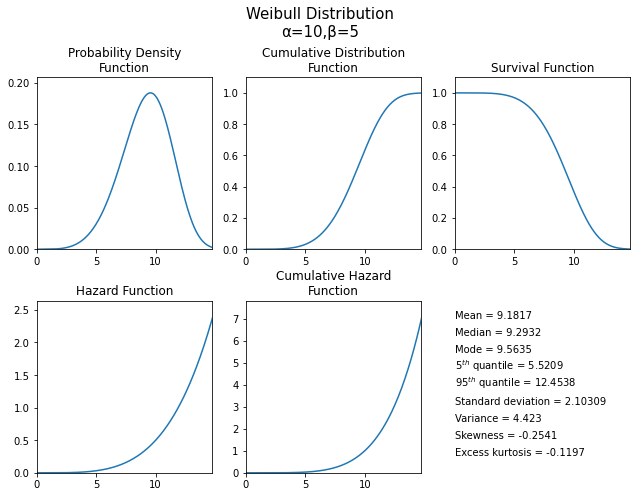

In [2]:
from reliability.Distributions import Weibull_Distribution

reliability_dist = Weibull_Distribution(alpha=10, beta=5)
reliability_dist.plot()

In [3]:
import gym
from gym import spaces
import time
import numpy as np
import pandas as pd
# from gym_pm.envs.Objects import Factory
from IPython.display import display, clear_output

class Assembly_Env(gym.Env):
    metadata = {"render.modes": ["console"]}

    def __init__(self, env_config=None, output_rate=7, 
                 alpha=10, beta=5, capacity=35, repair_cost=30, 
                 resupply_cost=3, storage_cost=2, backlog_cost=10,
                 resupply_qty=28, lead_time=3, product_price=75):

        # Cost elements
        self.output_rate = output_rate
        self.capacity = capacity
        self.repair_cost = repair_cost
        self.resupply_cost = resupply_cost
        self.storage_cost = storage_cost
        self.backlog_cost = backlog_cost
        self.resupply_qty = resupply_qty
        self.lead_time = lead_time
        self.product_price = product_price

        # Episode length
        self.max_duration = 3000 # max time

        # Initialize everything
        self.alpha = alpha
        self.beta = beta
        self.reset()

        self.max_resource = self.max_duration * max(output_rate, resupply_qty) + self.machine.demand_dist.sum() # Set to a high value

        # action space
        self.action_space = spaces.Discrete(3)
        # obs space
        self.observation_space = spaces.Dict({
                "age": spaces.Box(low=0., high=self.max_duration, shape=(1,), dtype=np.float32),
                "Failure": spaces.MultiBinary(1),
                "resources": spaces.Box(low=0., high=self.max_resource, shape=(1,), dtype=np.float32),
                "backlog": spaces.Box(low=0., high=self.max_resource, shape=(1,), dtype=np.float32),
                "output": spaces.Box(low=0., high=self.max_resource, shape=(1,), dtype=np.float32),
                "resupply_queue": spaces.Box(low=0., high=self.max_resource, shape=(1,), dtype=np.float32)
                })

    def reset(self):

        # reset timer
        self.timer = 0      
        # reset backlog
        self.backlog = 0

        self.machine = Factory(output_rate=self.output_rate, 
                               alpha=self.alpha,
                               beta=self.beta,
                               capacity=self.capacity,
                               episode_length=self.max_duration,                 
                               repair_cost=self.repair_cost, 
                               resupply_cost=self.resupply_cost,
                               storage_cost=self.storage_cost, 
                               resupply_qty=self.resupply_qty,
                               lead_time=self.lead_time, 
                               product_price=self.product_price)

        return self.observation()

    def observation(self):

        state = {
            "age": [self.machine.age],
            "Failure": [-(self.machine.working - 1)],
            "resources": [self.machine.capacity],
            "backlog": [self.backlog],
            "output": [self.machine.output],
            "resupply_queue": [len(self.machine.resupply_list)]
        }

        state = {i: np.array(j, dtype='float32') for (i, j) in state.items()}

        return state

    def get_reward(self):

        reward = 0.
        # Repair Cost
        reward -= self.machine.repair_cost * self.machine.repair_status * self.machine.repair_time
        # Resupply Cost
        reward -= self.machine.resupply_cost * self.machine.resupply_status * self.machine.resupply_qty
        # Inventory Cost
        reward -= self.machine.capacity * self.machine.storage_cost
        reward -= self.machine.output * self.machine.storage_cost
        # Backlog Cost
        reward -= self.backlog * self.backlog_cost
        # Sales Revenue
        reward += self.machine.fulfilled_orders * self.machine.product_price
        if self.machine.working == False:
            reward -= 200

        return reward

    def check_done(self):

        if self.timer >= self.max_duration:
            done = True
        else:
            done = False

        return done

    def fulfil_demand(self):

        self.backlog += self.machine.demand_dist[self.timer]

        if self.machine.output == 0:
            self.machine.fulfilled_orders = 0
        elif self.backlog > self.machine.output:
            self.backlog -= self.machine.output
            self.machine.fulfilled_orders = self.machine.output
            self.machine.output = 0
        else:
            self.machine.output -= self.backlog 
            self.machine.fulfilled_orders = self.backlog
            self.backlog = 0

    def step(self, action):

        # Reset Status
        self.machine.repair_status = 0
        self.machine.resupply_status = 0

        # Replenish Stock
        self.machine.update_lt()
        # Deterioriation
        self.machine.failure_check()

        # Interactions (Add more as desired)
        if action == 0:
            self.machine.repair()
        elif action == 1:
            self.machine.resupply()
        else:
            pass

        # Inventory
        self.machine.update_inv()
        # Reduce Backlog
        self.fulfil_demand()

        obs = self.observation()
        reward = self.get_reward()
        done = self.check_done()
        info = {}

        self.timer += 1

        return obs, reward, done, info

    def render(self, mode="console"):

        result = pd.Series({i: j[0] for (i, j) in self.observation().items()})

        result['age'] = result['age'].astype(int)
        result.Failure = result.Failure.astype(bool)
        result['ttf'] = self.machine.ttf[0]
        result['repair_count'] = self.machine.repair_counter
        result['reward'] = self.get_reward()
        result['duration'] = int(self.timer)
        result['lead_time'] = self.machine.resupply_list.copy()
        result = result.to_frame('Results')
            
        if mode == 'human':

            clear_output(wait=True)
            display(result)
            time.sleep(1)

        return result

    def close(self):
        pass

# Test Environment

In [4]:
from stable_baselines3.common.env_checker import check_env

env = Assembly_Env()
check_env(env, warn=True)

In [5]:
env.reset()
for _ in range(5):
    env.render('human')
    env.step(env.action_space.sample()) # take a random action

    if env.check_done():
        break

,Results
age,4
Failure,False
resources,7
backlog,0
output,0
resupply_queue,2
ttf,10
repair_count,0
reward,502
duration,4
